In [17]:
import os
import torch
from dataset import DCDataset, share4v_train_dataset

In [18]:
stage=0 #MCL stage
num_gpus=8  # number of gpus used in inference.py
expname='clipmoe' # experiment name, please use the same for the whole MCL process, without stage number
savepath='./save_mcl_tmp'   # path to load the output of inference.py and to save the obtained pseudo-labels

num_clusters_per_modal=3

num_clusters=num_clusters_per_modal*num_clusters_per_modal # number of clusters for each stage in MCL
cluster_batch_size=1000000  # batch size for clustering. We use mini-batch Kmeans for clustering
cluster_max_iter=500    # max number of iterations for clustering
cluster_tol=1e-5    # tolerance for clustering
my_dataset = share4v_train_dataset()

In [19]:
# integrate saved features from all GPUs from inference_DDP_longclip_slurm.py
image_feature_list=[]
text_feature_list=[]
indices_list=[]
for rank in range(num_gpus):
    saving=torch.load(os.path.join(savepath, '{}_{}_{}_{}.pt'.format(expname, stage, 'features',rank)))
    image_feature,text_feature, indices=saving['image_features'],saving['text_features'], saving['indices']
    image_feature_list.append(image_feature)
    text_feature_list.append(text_feature)
    indices_list.append(indices)
image_feature_list=torch.cat(image_feature_list, dim=0)
text_feature_list=torch.cat(text_feature_list, dim=0)
indices_list=torch.cat(indices_list, dim=0)

image_features=torch.zeros(len(my_dataset), image_feature_list.size(1), dtype=torch.float16)
image_features[indices_list]=image_feature_list
image_features=image_features.numpy()

text_features=torch.zeros(len(my_dataset), text_feature_list.size(1), dtype=torch.float16)
text_features[indices_list]=text_feature_list
text_features=text_features.numpy()
    

In [20]:
# do mini-batch Kmeans clustering
from sklearn.cluster import MiniBatchKMeans
kmeans_i = MiniBatchKMeans(
    n_clusters=num_clusters_per_modal, 
    batch_size=cluster_batch_size, 
    max_iter=cluster_max_iter,
    tol=cluster_tol,
    verbose=1,
    n_init='auto')

kmeans_i.fit(image_features)

cluster_labels_i = torch.LongTensor(kmeans_i.predict(image_features))


kmeans_t = MiniBatchKMeans(
    n_clusters=num_clusters_per_modal, 
    batch_size=cluster_batch_size, 
    max_iter=cluster_max_iter,
    tol=cluster_tol,
    verbose=1,
    n_init='auto')

kmeans_t.fit(text_features)

cluster_labels_t = torch.LongTensor(kmeans_t.predict(text_features))

cluster_labels=cluster_labels_t*num_clusters_per_modal+cluster_labels_i
torch.save(cluster_labels,os.path.join(savepath, '{}_{}_{}.pt'.format(expname, stage, 'cluster_labels')))


Init 1/1 with method k-means++
Inertia for init 1/1: 365251.06288538483
Minibatch step 1/500: mean batch inertia: 0.3652535961238412
Minibatch step 2/500: mean batch inertia: 0.19841850892257867, ewa inertia: 0.19841850892257867
Minibatch step 3/500: mean batch inertia: 0.19714915800895055, ewa inertia: 0.19714915800895055
Minibatch step 4/500: mean batch inertia: 0.19656850664992986, ewa inertia: 0.19656850664992986
Minibatch step 5/500: mean batch inertia: 0.196282861289549, ewa inertia: 0.196282861289549
Minibatch step 6/500: mean batch inertia: 0.19610367445549523, ewa inertia: 0.19610367445549523
Minibatch step 7/500: mean batch inertia: 0.19605459548268195, ewa inertia: 0.19605459548268195
Minibatch step 8/500: mean batch inertia: 0.19605719948113778, ewa inertia: 0.19605719948113778
Minibatch step 9/500: mean batch inertia: 0.19597595770580048, ewa inertia: 0.19597595770580048
Minibatch step 10/500: mean batch inertia: 0.19598970210994213, ewa inertia: 0.19598970210994213
Miniba

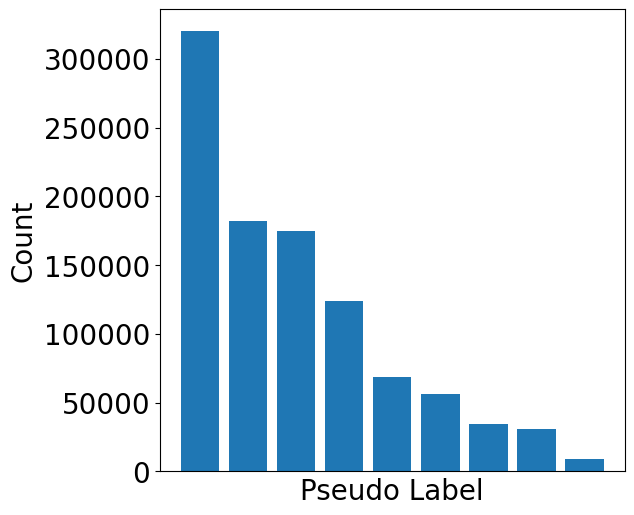

In [21]:
# plot the distribution of the pseudo labels
import matplotlib.pyplot as plt


# 假设L是你的LongTensor
L = cluster_labels

# 获取唯一值及其计数
unique_elements, counts = torch.unique(L, return_counts=True)

# 结合unique_elements和counts，然后根据counts排序
combined = list(zip(unique_elements.numpy(), counts.numpy()))
sorted_combined = sorted(combined, key=lambda x: x[1], reverse=True)  # 根据counts降序排序

# 分解回sorted unique elements和sorted counts
sorted_unique_elements, sorted_counts = zip(*sorted_combined)

# 绘制排序后的结果
plt.figure(figsize=(6, 6))
plt.bar(range(len(sorted_unique_elements)), sorted_counts, tick_label=sorted_unique_elements)
#plt.title('Element Counts Sorted')

plt.xticks([])

# 设置竖轴的格式为科学记数法
#plt.ylim(1e2,1e5)
ax = plt.gca()
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(LogFormatterSciNotation())
ax.set_yscale('linear')  # 改为线性缩放
ax.yaxis.set_major_formatter(plt.ScalarFormatter())

plt.xlabel('Pseudo Label',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('cluster0.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [22]:
#integrate the clustering labels from the previous stages to get the pseudo labels for the current stage
cls=torch.zeros(cluster_labels.shape[0],dtype=torch.long)
for s in range(stage+1):
    cl=torch.load(os.path.join(savepath, '{}_{}_{}.pt'.format(expname, s, 'cluster_labels')))
    cls=cls*num_clusters+cl
    unique_elements, counts = torch.unique(cls, return_counts=True)
    print(len(counts))
torch.save(cls[:1000000],os.path.join(savepath, '{}_{}_{}.pt'.format(expname, stage, 'pseudo_labels')))

9
81
696


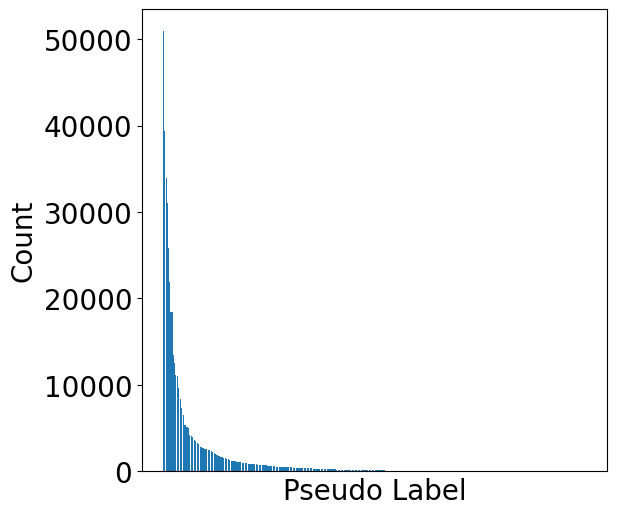

In [23]:
# plot the distribution of the pseudo labels
import matplotlib.pyplot as plt


# 假设L是你的LongTensor
L = cls

# 获取唯一值及其计数
unique_elements, counts = torch.unique(L, return_counts=True)

# 结合unique_elements和counts，然后根据counts排序
combined = list(zip(unique_elements.numpy(), counts.numpy()))
sorted_combined = sorted(combined, key=lambda x: x[1], reverse=True)  # 根据counts降序排序

# 分解回sorted unique elements和sorted counts
sorted_unique_elements, sorted_counts = zip(*sorted_combined)

# 绘制排序后的结果
plt.figure(figsize=(6, 6))
plt.bar(range(len(sorted_unique_elements)), sorted_counts, tick_label=sorted_unique_elements)
#plt.title('Element Counts Sorted')

plt.xticks([])

# 设置竖轴的格式为科学记数法
#plt.ylim(1e2,1e5)
ax = plt.gca()
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(LogFormatterSciNotation())
ax.set_yscale('linear')  # 改为线性缩放
ax.yaxis.set_major_formatter(plt.ScalarFormatter())

plt.xlabel('Pseudo Label',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('cluster0.pdf', format='pdf', bbox_inches='tight')
plt.show()